In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.utils_func import create_windows, sim_seasonal_data, sim_randomwalk

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

In [2]:
### CREATE SYNTHETIC DATA ###

np.random.seed(0)

n_series, timesteps = 1, 400

data1 = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                          level=0, amp=10, freq=24, measure_noise=4)

data2 = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                          level=0, amp=10, freq=24*7, measure_noise=4)

data3 = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                       process_noise=1, measure_noise=0)


data = data1[0] + data2[0] + data3[0]

In [3]:
### STORE DATA IN DF ###

df = pd.DataFrame({
    'X_1':data1[0],
    'X_2':data2[0],
    'X_3':data3[0],
    'Y':data
})

df.index = pd.date_range('2021', periods=len(df), freq='H')
cols = df.columns

print(df.shape)
df.head()

(400, 4)


,X_1,X_2,X_3,Y
2021-01-01 00:00:00,7.056209,-2.394616,1.411172,6.072766
2021-01-01 01:00:00,4.188819,-4.089676,2.196976,2.296119
2021-01-01 02:00:00,8.914952,3.813954,2.139506,14.868412
2021-01-01 03:00:00,16.034641,2.544816,1.748289,20.327746
2021-01-01 04:00:00,16.130486,-5.583731,2.689207,13.235962


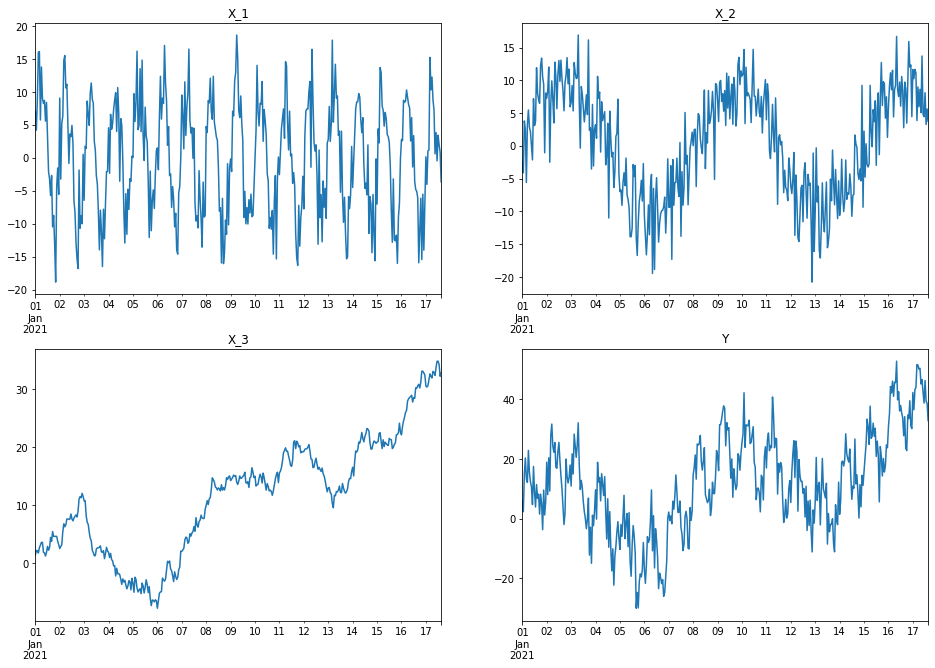

In [4]:
### PLOT SYNTHETIC DATA ###

plt.figure(figsize=(16,11))

for i,c in enumerate(cols):
    
    plt.subplot(2,2,i+1)
    df[c].plot(ax=plt.gca(), title=c); plt.xlabel(None)

In [5]:
### TRAIN TEST SPLIT ###

window_shape = 24
time_h = 6

train = df.head(200)
test = df[~df.index.isin(train.index)]

In [6]:
### SMOOTH TRAIN DATA ###

smoother = SpectralSmoother(smooth_fraction=0.18, pad_len=12)
smoother.smooth(train.T)

<tsmoothie.smoother.SpectralSmoother>

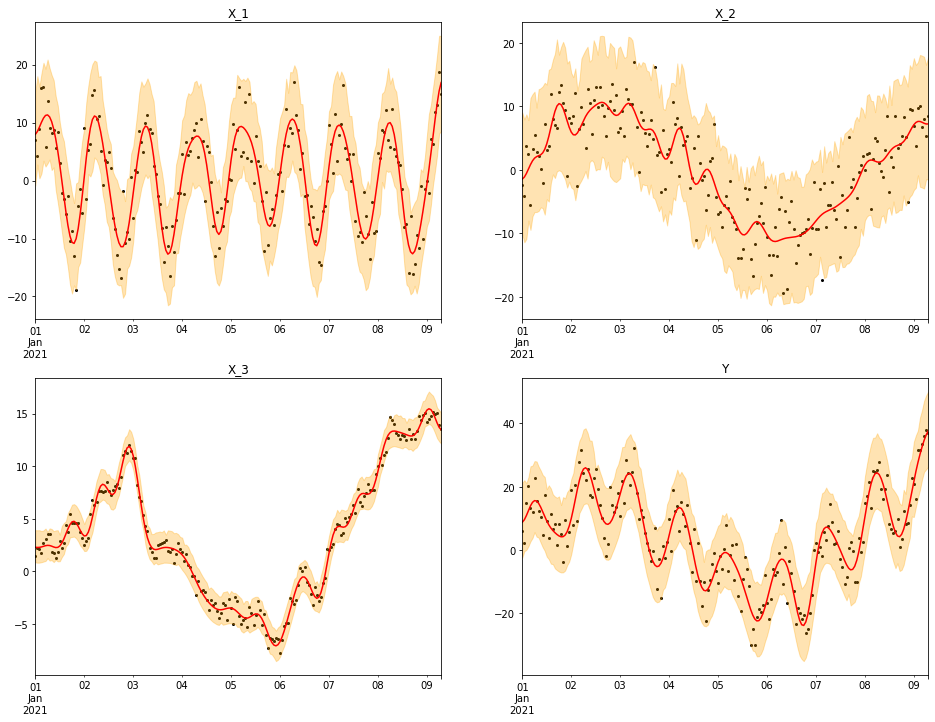

In [7]:
### BOOTSTRAP TRAIN DATA (ONLY FOR PLOTTING) ###

plt.figure(figsize=(16,12))

for i,c in enumerate(cols):
    
    plt.subplot(2,2,i+1)
    
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                           bootstrap_type='mbb', block_length=24)
    bts_samples = bts.sample(train[c], n_samples=100)
    
    pd.Series(smoother.smooth_data[i], index=train.index).plot(c='red')
    plt.scatter(train.index, smoother.data[i], c='black', s=4)
    plt.fill_between(train.index, bts_samples.min(0), bts_samples.max(0), alpha=0.3, color='orange')
    plt.title(c)

In [8]:
### CREATE TEST WINDOWS AND STANDARDIZE ###

X_test = create_windows(test[cols], window_shape=window_shape, end_id=-time_h)
y_test = create_windows(test[cols], window_shape=time_h, start_id=window_shape)

prev_test = X_test[:,[-1],:]
X_test = X_test - prev_test
y_test = np.squeeze(y_test[...,[-1]], -1)

X_test.shape, y_test.shape

((171, 24, 4), (171, 6))

In [9]:
### BOOSTRAP TRAIN SERIES ###

bts_samples = []

for i,c in enumerate(cols):
    
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                                                bootstrap_type='mbb', block_length=24)
    bts_samples.append(bts.sample(train[c], n_samples=30))
    
bts_samples = np.stack(bts_samples, axis=-1)
bts_samples.shape

(30, 200, 4)

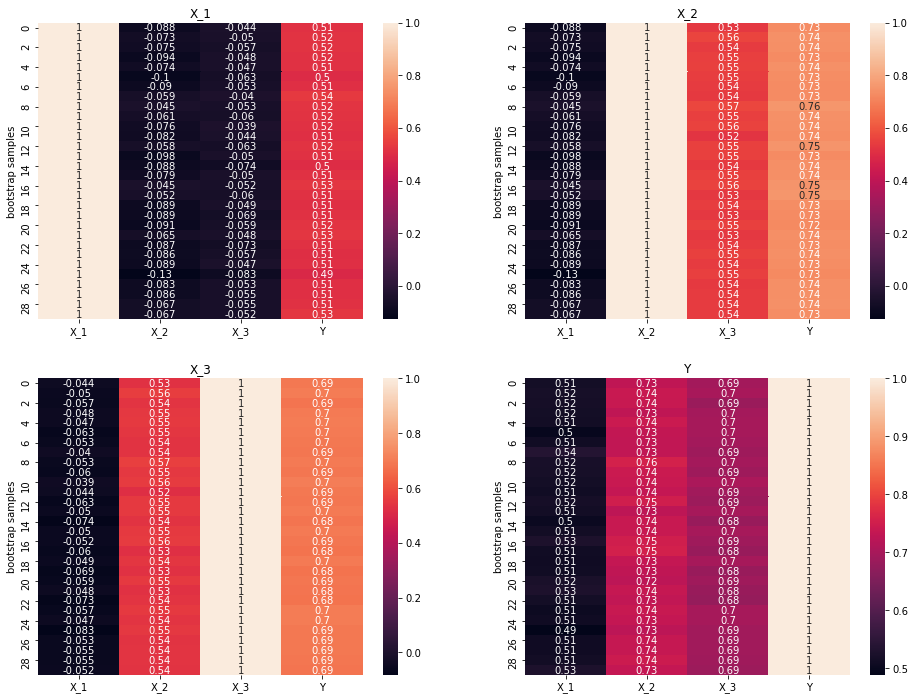

In [10]:
### SHOW CORRELATION BETWEEN BOOTSTRAPPED SAMPLES ###

corr_samples = np.stack([np.corrcoef(n.T) for n in bts_samples], 0)

plt.figure(figsize=(16,12))

for i,c in enumerate(cols):
    
    plt.subplot(2,2,i+1)
    sns.heatmap(corr_samples[:,i,:], annot=True)
    plt.ylabel('bootstrap samples'); plt.xticks(np.arange(0.5, len(cols)), cols)
    plt.title(c)

In [11]:
### CREATE TRAIN/VALIDATION WINDOWS W/ BOOTSTRAP ###

_X = create_windows(train[cols], window_shape=window_shape, end_id=-time_h)
_y = create_windows(train[cols], window_shape=time_h, start_id=window_shape)
_X_train, _X_val, _y_train, _y_val = train_test_split(_X, _y, test_size=window_shape*3, shuffle=False)
X_train, X_val, y_train, y_val = [_X_train], [_X_val], [_y_train], [_y_val]

for i in range(bts_samples.shape[0]):

    _X = create_windows(bts_samples[i], window_shape=window_shape, end_id=-time_h)
    _y = create_windows(bts_samples[i], window_shape=time_h, start_id=window_shape)
    _X_train, _X_val, _y_train, _y_val = train_test_split(_X, _y, test_size=window_shape*3, shuffle=False)
    X_train.append(_X_train)
    y_train.append(_y_train)
    
X_train = np.concatenate(X_train); X_val = np.concatenate(X_val)
y_train = np.concatenate(y_train); y_val = np.concatenate(y_val)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3069, 24, 4) (3069, 6, 4)
(72, 24, 4) (72, 6, 4)


In [12]:
### STANDARDIZE TRAIN/VALIDATION WINDOWS ###

prev_train = X_train[:,[-1],:]
prev_val = X_val[:,[-1],:]

y_train = y_train[...,[-1]] - prev_train[...,[-1]]
X_train = X_train - prev_train

y_val = y_val[...,[-1]] - prev_val[...,[-1]]
X_val = X_val - prev_val

In [13]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)
    
    inp = Input((window_shape,len(cols)))
    enc = LSTM(param['lstm_unit'], activation=param['lstm_act'], 
               return_sequences=False)(inp)
    x = RepeatVector(time_h)(enc)
    dec = LSTM(param['lstm_unit'], activation=param['lstm_act'],
               return_sequences=True)(x)
    
    out = TimeDistributed(Dense(1))(dec)
    
    model = Model(inp, out)
    model.compile(Adam(lr=param['lr']), 'mse')
    
    return model

In [14]:
### TRAIN W/ BOOTSTRAPPED SAMPLES ###

param_grid = {
    'lstm_unit': [128,64], 
    'lstm_act': ['tanh','relu'],
    'lr': [1e-4,1e-3], 
    'epochs': 100, 
    'batch_size': [16,32,128]
}

es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[es])


24 trials detected for ('lstm_unit', 'lstm_act', 'lr', 'epochs', 'batch_size')

***** (1/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.0001, 'epochs': 100, 'batch_size': 16})
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
SCORE: 59.28572 at epoch 5

***** (2/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.0001, 'epochs': 100, 'batch_size': 32})
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
SCORE: 55.69127 at epoch 8

***** (3/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.0001, 'epochs': 100, 'batch_size': 128})
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
SCORE: 59.67992 at epoch 17

***** (4/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.001, 'epochs': 100, 'batch_size': 16})
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
SCORE: 50.49247 at epoch 5

***** (5/24) *****

In [15]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 64, 'lstm_act': 'relu', 'lr': 0.001, 'epochs': 5, 'batch_size': 32, 'steps_per_epoch': 96}


In [16]:
### COMPUTE PREDICTIONS ON TEST ###

pred_boot = kgs.best_model.predict(X_test)
pred_boot = np.squeeze(pred_boot + prev_test[...,[-1]], -1)

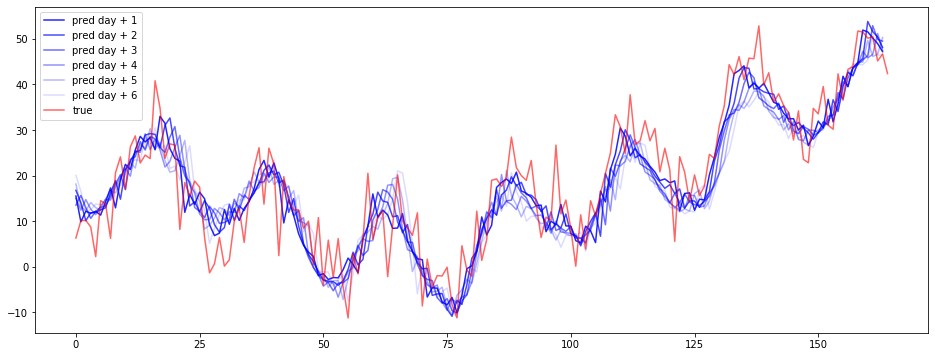

In [17]:
### PLOT PREDICTIONS ON TEST ###

plt.figure(figsize=(16,6))

for t_h in range(time_h):
    plt.plot(pred_boot[(time_h-t_h):-(t_h+1),t_h], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"pred day + {t_h+1}")

plt.plot(y_test[time_h:,0], 
         c='red', alpha=0.6, label='true')

plt.legend(); plt.show()

In [18]:
### CREATE TRAIN/VALIDATION WINDOWS W/O BOOTSTRAP ###

_X = create_windows(train[cols], window_shape=window_shape, end_id=-time_h)
_y = create_windows(train[cols], window_shape=time_h, start_id=window_shape)
X_train, X_val, y_train, y_val = train_test_split(_X, _y, test_size=window_shape*3, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(99, 24, 4) (99, 6, 4)
(72, 24, 4) (72, 6, 4)


In [19]:
### STANDARDIZE TRAIN/VALIDATION WINDOWS ###

prev_train = X_train[:,[-1],:]
prev_val = X_val[:,[-1],:]

y_train = y_train[...,[-1]] - prev_train[...,[-1]]
X_train = X_train - prev_train

y_val = y_val[...,[-1]] - prev_val[...,[-1]]
X_val = X_val - prev_val

In [20]:
### TRAIN W/O BOOTSTRAPPED SAMPLES ###

param_grid = {
    'lstm_unit': [128,64], 
    'lstm_act': ['tanh','relu'],
    'lr': [1e-4,1e-3], 
    'epochs': 100, 
    'batch_size': [16,32,128]
}

es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[es])


24 trials detected for ('lstm_unit', 'lstm_act', 'lr', 'epochs', 'batch_size')

***** (1/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.0001, 'epochs': 100, 'batch_size': 16})
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
SCORE: 123.58402 at epoch 10

***** (2/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.0001, 'epochs': 100, 'batch_size': 32})
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
SCORE: 123.83365 at epoch 12

***** (3/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.0001, 'epochs': 100, 'batch_size': 128})
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
SCORE: 123.97044 at epoch 38

***** (4/24) *****
Search({'lstm_unit': 128, 'lstm_act': 'tanh', 'lr': 0.001, 'epochs': 100, 'batch_size': 16})
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
SCORE: 90.42303 at epoch 7

***** (5/24) 

In [21]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 128, 'lstm_act': 'relu', 'lr': 0.001, 'epochs': 14, 'batch_size': 16, 'steps_per_epoch': 7}


In [22]:
### COMPUTE PREDICTIONS ON TEST ###

pred = kgs.best_model.predict(X_test)
pred = np.squeeze(pred + prev_test[...,[-1]], -1)

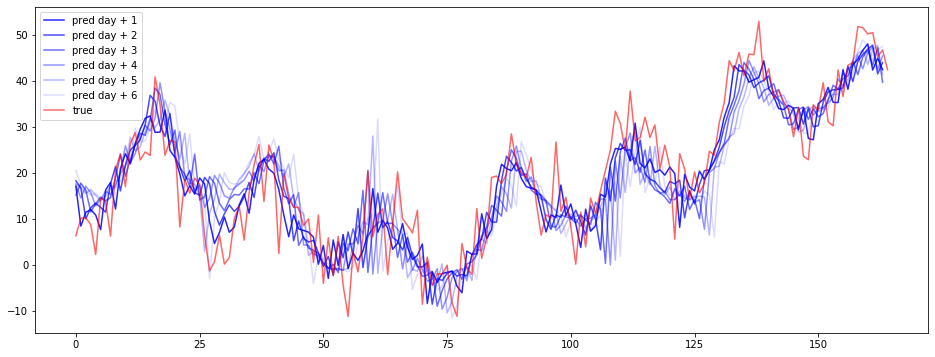

In [23]:
### PLOT PREDICTIONS ON TEST ###

plt.figure(figsize=(16,6))

for t_h in range(time_h):
    plt.plot(pred[(time_h-t_h):-(t_h+1),t_h], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"pred day + {t_h+1}")

plt.plot(y_test[time_h:,0], 
         c='red', alpha=0.6, label='true')

plt.legend(); plt.show()

In [24]:
### GET PERFORMANCES ON TEST ###

mse_model = {}
mse_model_boot = {}
mse_baseline = {}

for t_h in range(time_h):

    _mse = mse(y_test[1:,t_h], y_test[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse 

    _mse = mse(y_test[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse 
    
    _mse = mse(y_test[:,t_h], pred_boot[:,t_h])
    mse_model_boot[f"day + {t_h+1}"] = _mse 

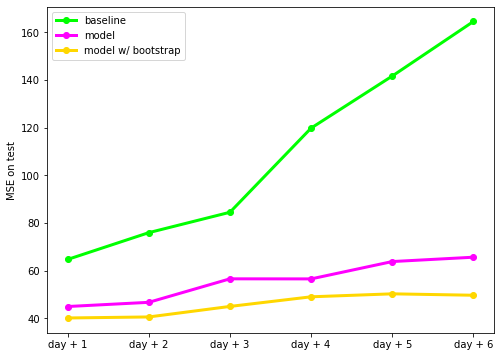

In [25]:
### PLOT AND COMPARE PERFORMANCES ###

plt.figure(figsize=(8,6))

plt.plot(list(mse_baseline.values()), label='baseline', 
         c='lime', linewidth=3, marker='o')
plt.plot(list(mse_model.values()), label='model', 
         c='magenta', linewidth=3, marker='o')
plt.plot(list(mse_model_boot.values()), label='model w/ bootstrap', 
         c='gold', linewidth=3, marker='o')

plt.xticks(range(time_h), mse_baseline.keys())
plt.ylabel('MSE on test'); plt.legend()